In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

# 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/input/data/train/DCM"
LABEL_ROOT = "/opt/ml/input/data/train/outputs_json"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

pngs = sorted(pngs)
jsons = sorted(jsons)

# 모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

print('pngs, jsons')
print(len(pngs),len(jsons))

/opt/ml/input/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pngs, jsons
800 800


In [2]:

BATCH_SIZE = 8
LR = 1e-4
RANDOM_SEED = 21

NUM_EPOCHS = 23    # CHANGE
VAL_EVERY = 1

if not os.path.isdir("./workspace/"):
    os.mkdir("./workspace/")
    
SAVED_DIR = "./workspace/results_baseline/"

if not os.path.isdir(SAVED_DIR):                                                           
    os.mkdir(SAVED_DIR)
    

class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)

        # print(_filenames)
        #['ID001/image1661130828152_R.png' 'ID001/image1661130891365_L.png'
        # 'ID002/image1661144206667.png' 'ID002/image1661144246917.png'
        
        # print(_labelnames)
        # ['ID001/image1661130828152_R.json' 'ID001/image1661130891365_L.json'
        #  'ID002/image1661144206667.json' 'ID002/image1661144246917.json'
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]

        # print(groups)
        #['ID001', 'ID001', 'ID002', 'ID002', 'ID003', 'ID003', 'ID004', 'ID004', 'ID005', 'ID005', 'ID00
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            # print(i,x,y)
            # 5개로 나뉘는데, 5가지 폴드로 나뉨.
            # print(len(x),len(y),'lenx y')
            #          640    160            
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                # filenames = list(_filenames[x])
                labelnames += list(_labelnames[y])
                # labelnames = list(_labelnames[x])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} #if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] #if self.is_train else label # 여기때문에 2048,2048이 된다.


        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label
    


tf = A.Resize(512, 512)
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)

image, label = train_dataset[0]
print('image shpae and label shape of valid set')
print(image.shape, label.shape)

# dataset eda + visualization

# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

print('len(train_dataset),len(valid_dataset)')
print(len(train_dataset),len(valid_dataset))
print()

# valid 데이터셋의 filenames 리스트 만들기
_filenames = np.array(pngs)
ys = [0 for fname in _filenames]
groups = [os.path.dirname(fname) for fname in _filenames]
gkf = GroupKFold(n_splits=5)
filenames = []
for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
    if i == 0:
        filenames += list(_filenames[y])

image shpae and label shape of valid set
torch.Size([3, 512, 512]) torch.Size([29, 512, 512])
len(train_dataset),len(valid_dataset)
640 160



# Inference

In [3]:
# model 경로를 입력하세요!
model = torch.load('/opt/ml/input/code/workspace/results_baseline/fcn_resnet50_best_model_06-07-21:36.pt')

# 테스트 데이터 경로를 입력하세요
IMAGE_ROOT = "/opt/ml/input/data/train/DCM"

In [22]:
def test(model, data_loader, thr=0.5,show_number=7):
    model = model.cuda()
    model.eval()

    with torch.no_grad():
        n_class = 29 # len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            if step== show_number:
                print('show image number :' ,show_number)
                images = images.cuda()    
                outputs = model(images)['out']


                # # restore original size
                # outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
                outputs = F.interpolate(outputs, size=(512, 512), mode="bilinear")
                outputs = torch.sigmoid(outputs) # 시그모이드를 통과한 값이됨.
                # outputs = outputs.detach().cpu().numpy()
                outputs = (outputs > thr).detach().cpu().numpy()
                break
        return outputs


In [26]:
VBATCH_SIZE = 2
valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=VBATCH_SIZE,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [27]:
output = test(model,valid_loader)
print(len(output)) # valid dataloader batch size 만큼 나옴.

  9%|▉         | 7/80 [00:09<01:38,  1.35s/it]


show image number : 7
2


# Result Visualization

In [28]:
show_number = 7
image, label = valid_dataset[show_number*VBATCH_SIZE]
# show_number*VBATCH_SIZE ,show_number*VBATCH_SIZE+1 ,show_number*VBATCH_SIZE+2 .. show_number*VBATCH_SIZE + bathsize-1까지
print('image.shape,              label.shape,                 output.shape')
print(image.shape, label.shape, output.shape)
# 여기에서 이미지는 안씀.

최대로 겹친 구간 수 :  3.0
(512, 512)


/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_i

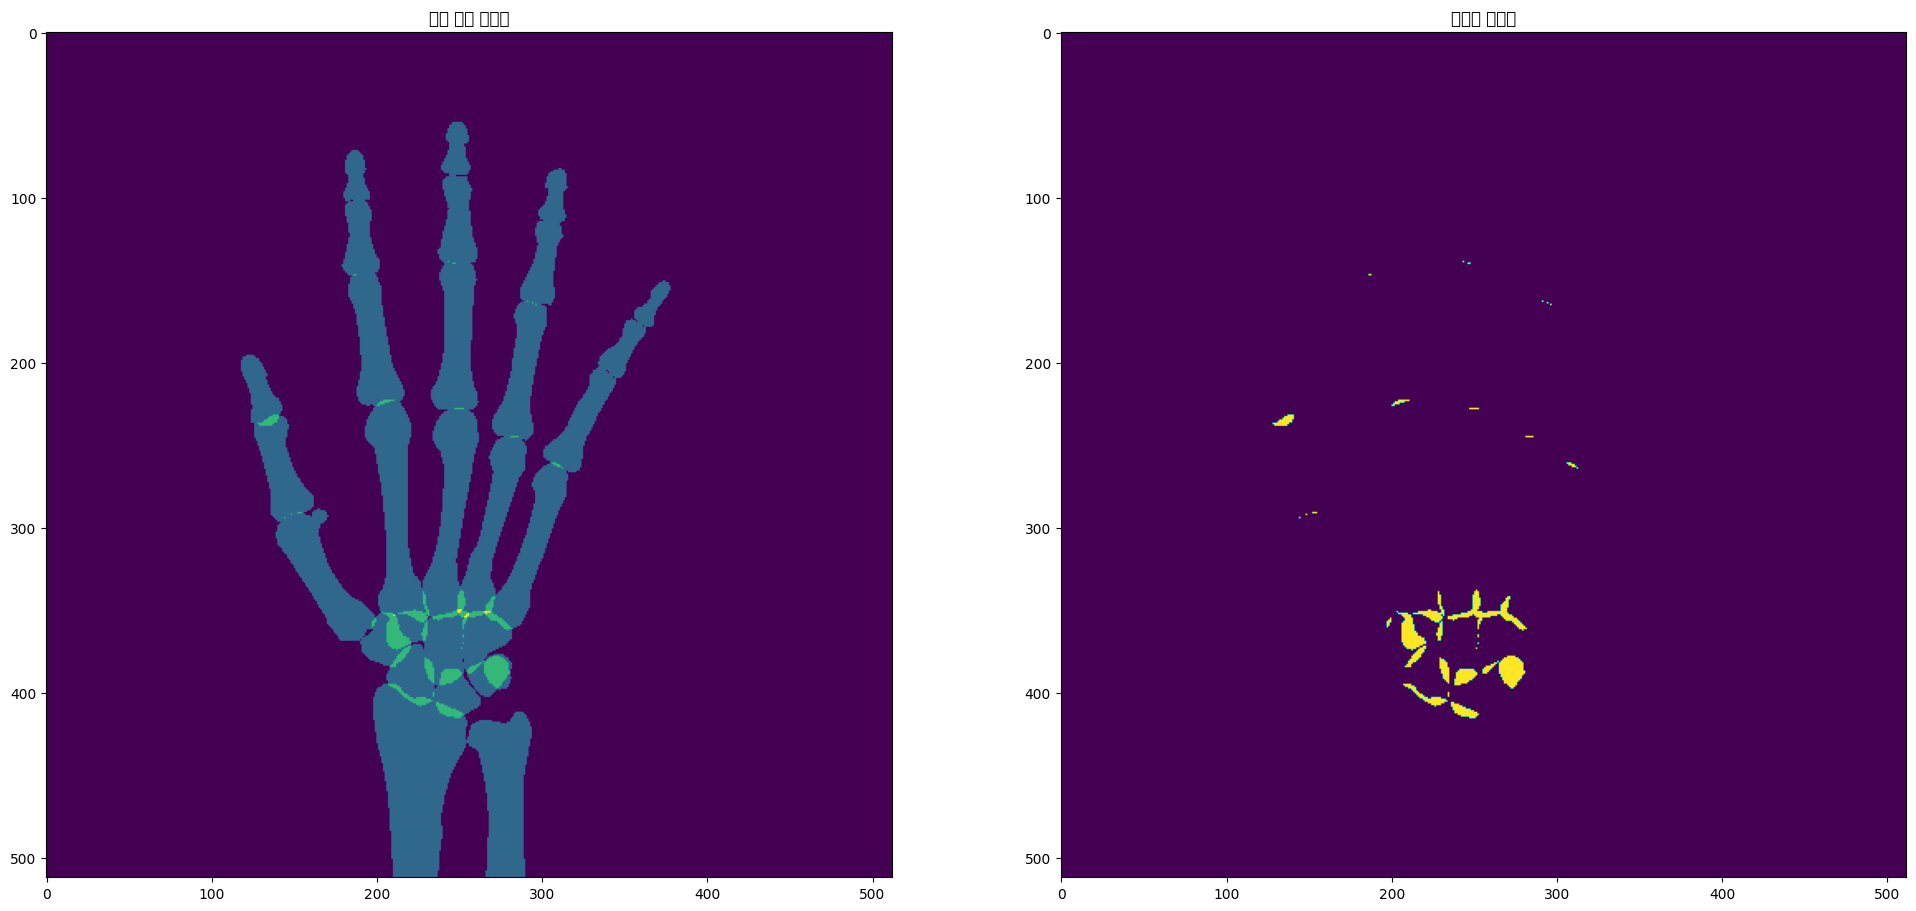

In [53]:
# image, label = valid_dataset[193]
input = label.numpy()
input = np.transpose(input,(1,2,0)) # 1038, 1920, 3

result = np.zeros((input.shape[0],input.shape[1]))


for i in range(29):
    # plt.imshow(input[:,:,i])
    # plt.show()
    result += input[:,:,i]
    
fig, ax = plt.subplots(1,2,figsize=(24, 12))
# plt.imshow(result)
ax[0].imshow(result)
ax[0].set_title('라벨 정답 이미지')



aa = list(result.flatten())
print('최대로 겹친 구간 수 : ',max(aa))

# print over 1
res = result.copy() # 전체 가져와서 1을 더해줌.
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        if res[i,j] > 1:
            res[i,j] = 1
        else:
            res[i,j] = 0

print(res.shape)
# plt.imshow(res)

# Plotting the right image
ax[1].imshow(res)
ax[1].set_title('겹치는 이미지')


# Adjusting the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()

res3 = result.copy() # 1과 0으로 표시된 것.
for i in range(res3.shape[0]):
    for j in range(res3.shape[1]):
        if res3[i,j] > 0:
            res3[i,j] = 1
        else:
            res3[i,j] = 0
            




(512, 512, 29)
최대로 겹친 구간 수 :  2.0
(512, 512)


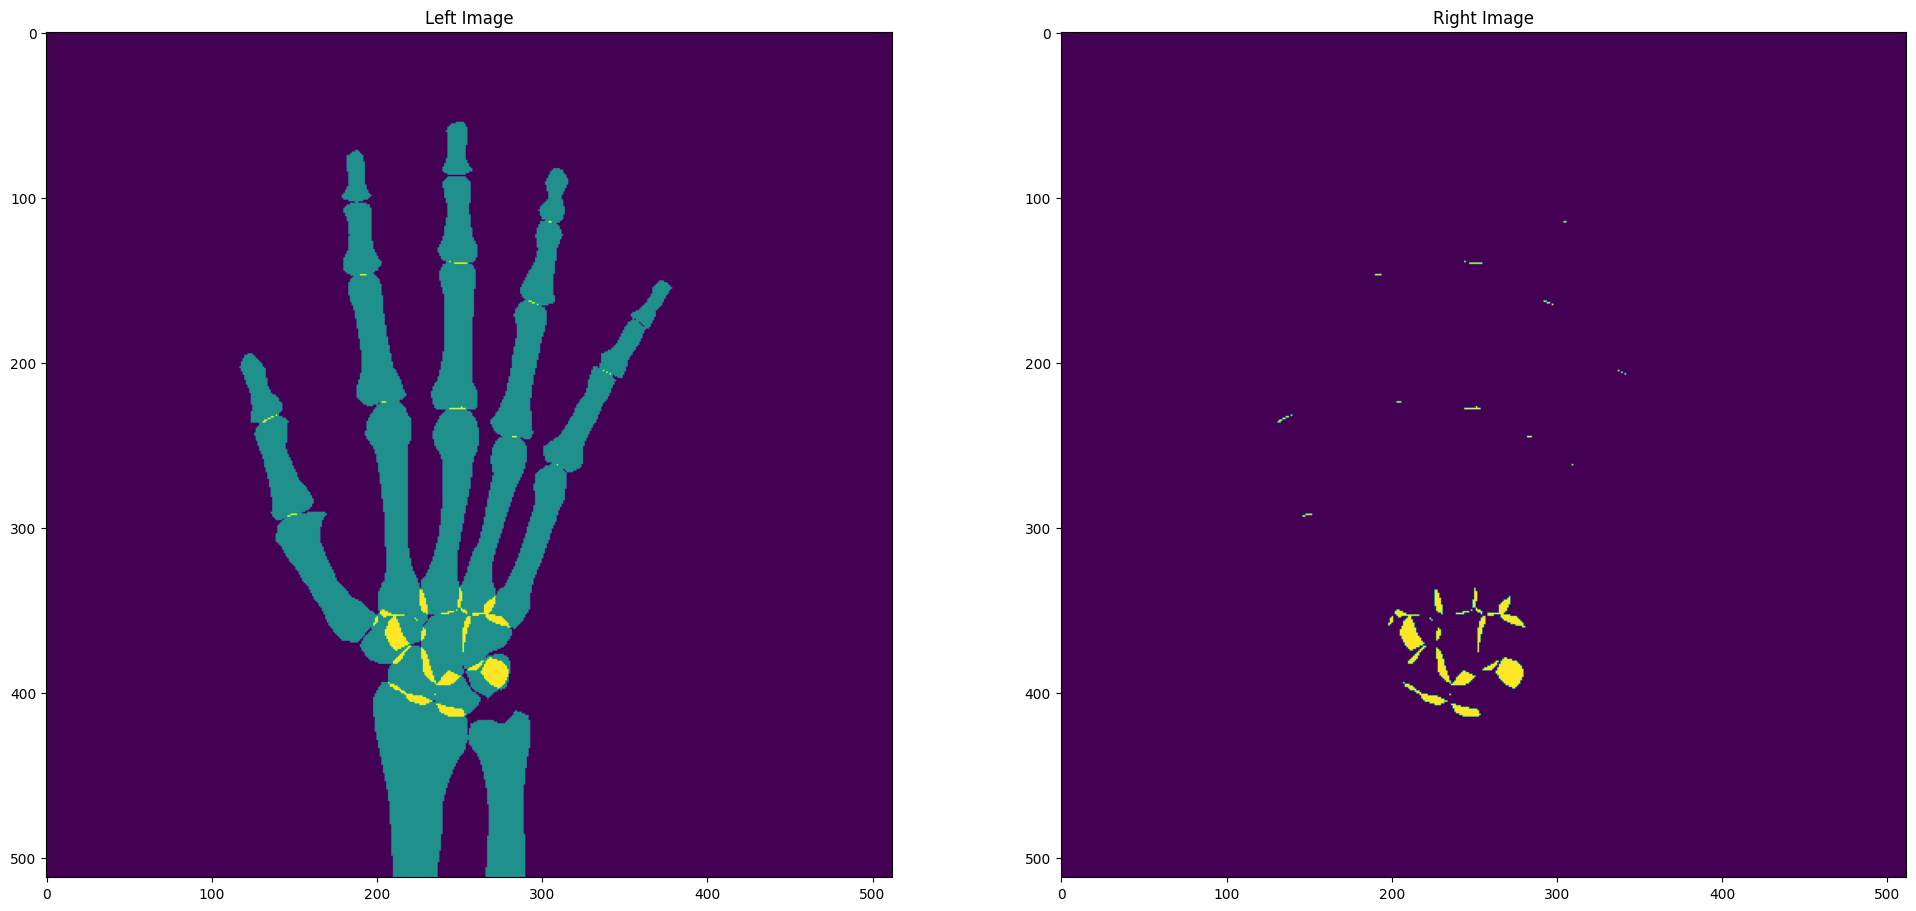

In [54]:

# image, label = valid_dataset[193]
# outputs = output.detach().cpu().numpy()
# outputs = output.detach().cpu().numpy()
outputs = output[0] # 첫번쨰꺼를 고른다!!!!
outputs = np.transpose(outputs,(1,2,0)) # 1038, 1920, 3
print(outputs.shape)


result2 = np.zeros((outputs.shape[0],outputs.shape[1])) # 다시 0으로 초기화


for i in range(29):
    # plt.imshow(outputs[:,:,i])
    # plt.show()
    result2 += outputs[:,:,i]

# result2를 보여준다. 근데 값이 정수가 아니게 되어있음 이거 제대로 고쳐야될까?
    
fig, ax = plt.subplots(1,2,figsize=(24, 12))
# plt.imshow(result2)
ax[0].imshow(result2)
ax[0].set_title('Left Image')



aa = list(result2.flatten())
print('최대로 겹친 구간 수 : ',max(aa))

# print over 1
res2 = result2.copy() # 1과 0으로 표시된 것.
for i in range(res2.shape[0]):
    for j in range(res2.shape[1]):
        if res2[i,j] > 1:
            res2[i,j] = 1
        else:
            res2[i,j] = 0

print(res2.shape)
# plt.imshow(res)

# Plotting the right image
ax[1].imshow(res2)
ax[1].set_title('Right Image')


# Adjusting the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()


            

res4 = result2.copy() # 1과 0으로 표시된 것.
for i in range(res4.shape[0]):
    for j in range(res4.shape[1]):
        if res4[i,j] > 0:
            res4[i,j] = 1
        else:
            res4[i,j] = 0




In [41]:
x1,y1,x2,y2 = 511,511,0,0
for i in range(res4.shape[0]):
    for j in range(res4.shape[1]):
        if res4[i,j] > 0 or res3[i,j] > 0:
            if i<=x1:
                x1=i
            if i>=x2:
                x2=i
            if j<=y1:
                y1=j
            if j>=y2:
                y2=j


x1,y1,x2,y2

(55, 117, 511, 378)

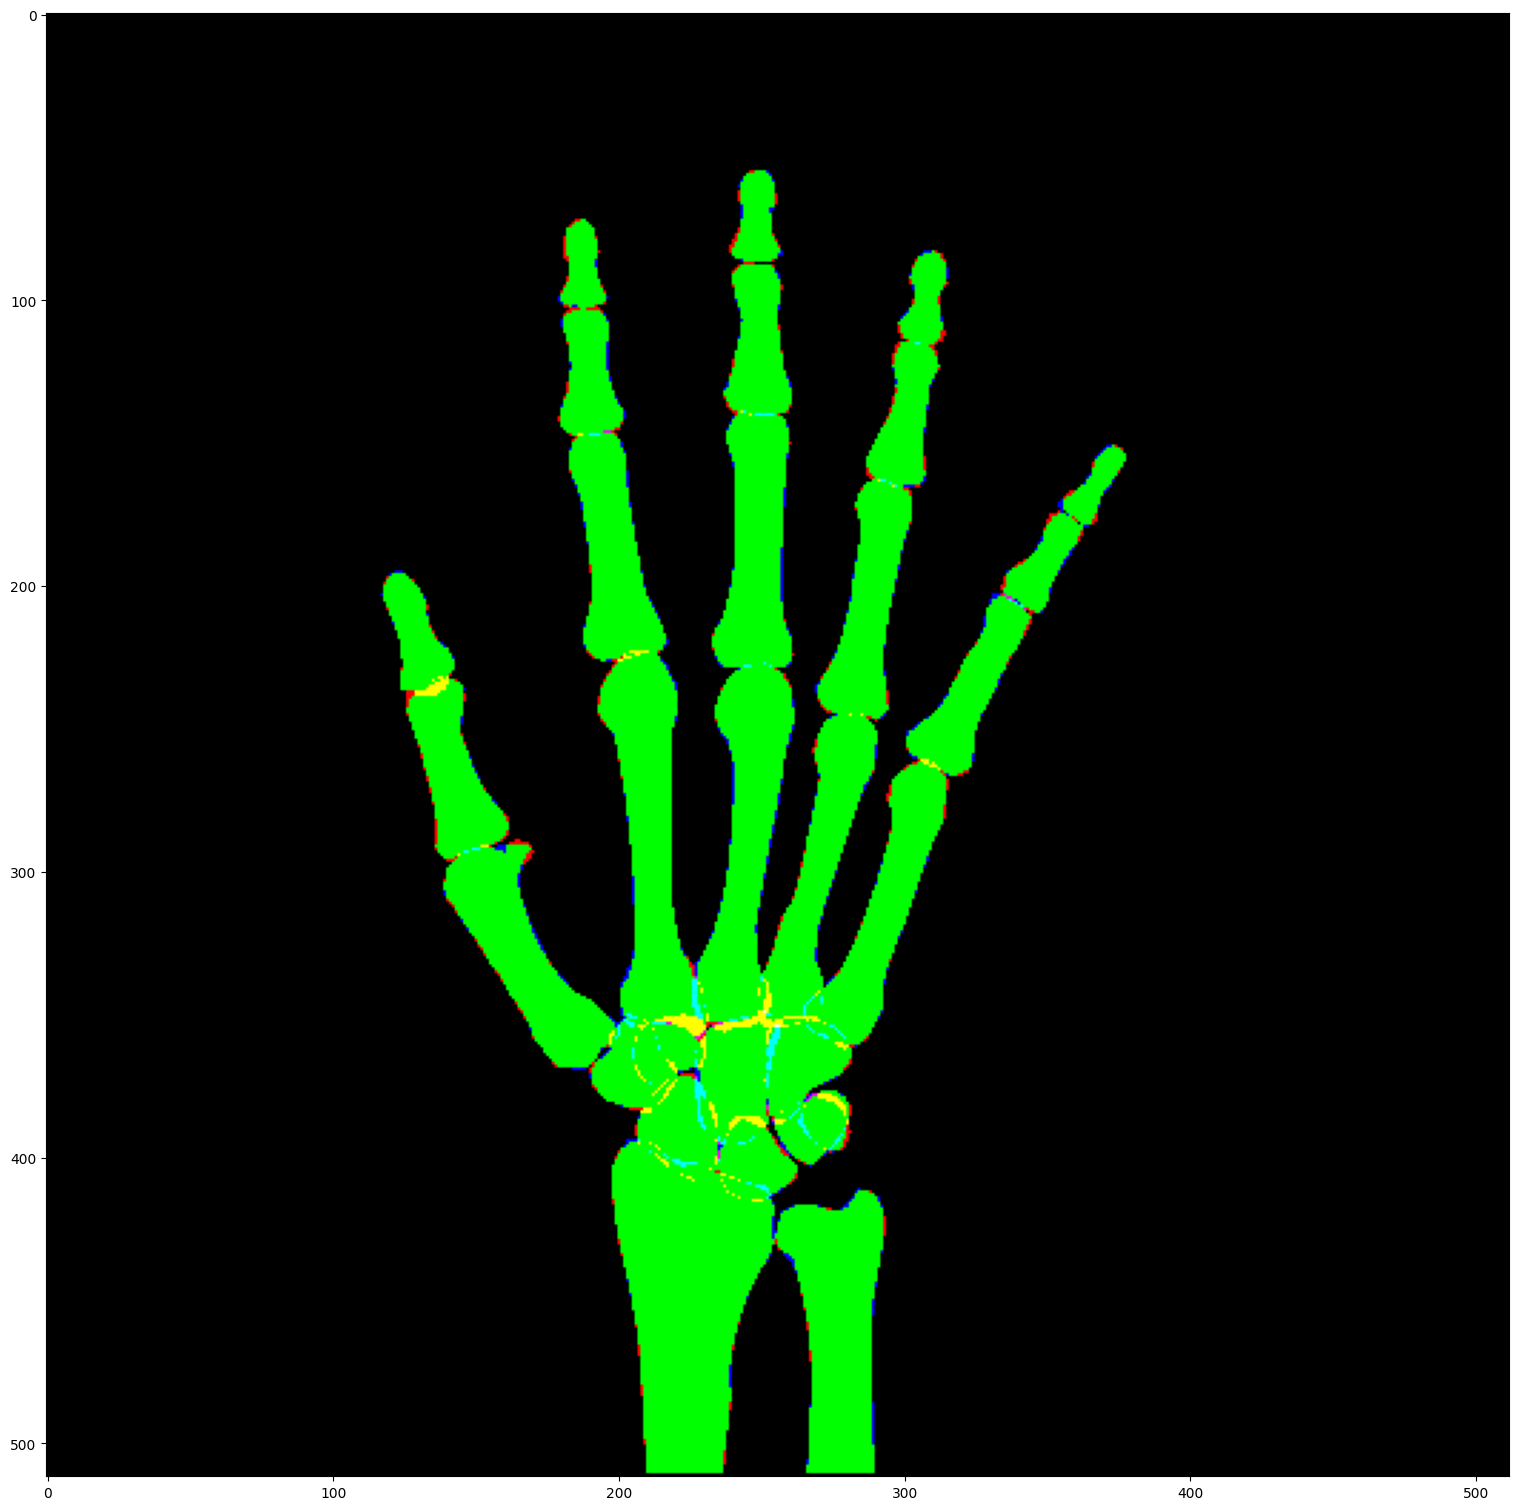

In [45]:
# image, label = valid_dataset[193]
input = label.numpy()
input = np.transpose(input,(1,2,0)) # 1038, 1920, 3

f1 = np.zeros((input.shape[0],input.shape[1],3))
# bgr

# plt.imshow(result2)  검정 화면나옴.

for i in range(29):
    # plt.imshow(input[:,:,i])
    # plt.show()
    for k in range(x1,x2):
        for l in range(y1,y2):
            if input[k,l,i]==1:
                if outputs[k,l,i]==1:
                    f1[k,l,1]=1 # green positive true
                elif outputs[k,l,i]==0:
                    f1[k,l,0]=1 # flase negative blue 실제 참 , 예측 거짓
            elif input[k,l,i]==0 and outputs[k,l,i]==1:
                f1[k,l,2]=1 # flase positive red 실제 거짓, 예측 참.

plt.figure(figsize=(19,19))
plt.imshow(f1)
    



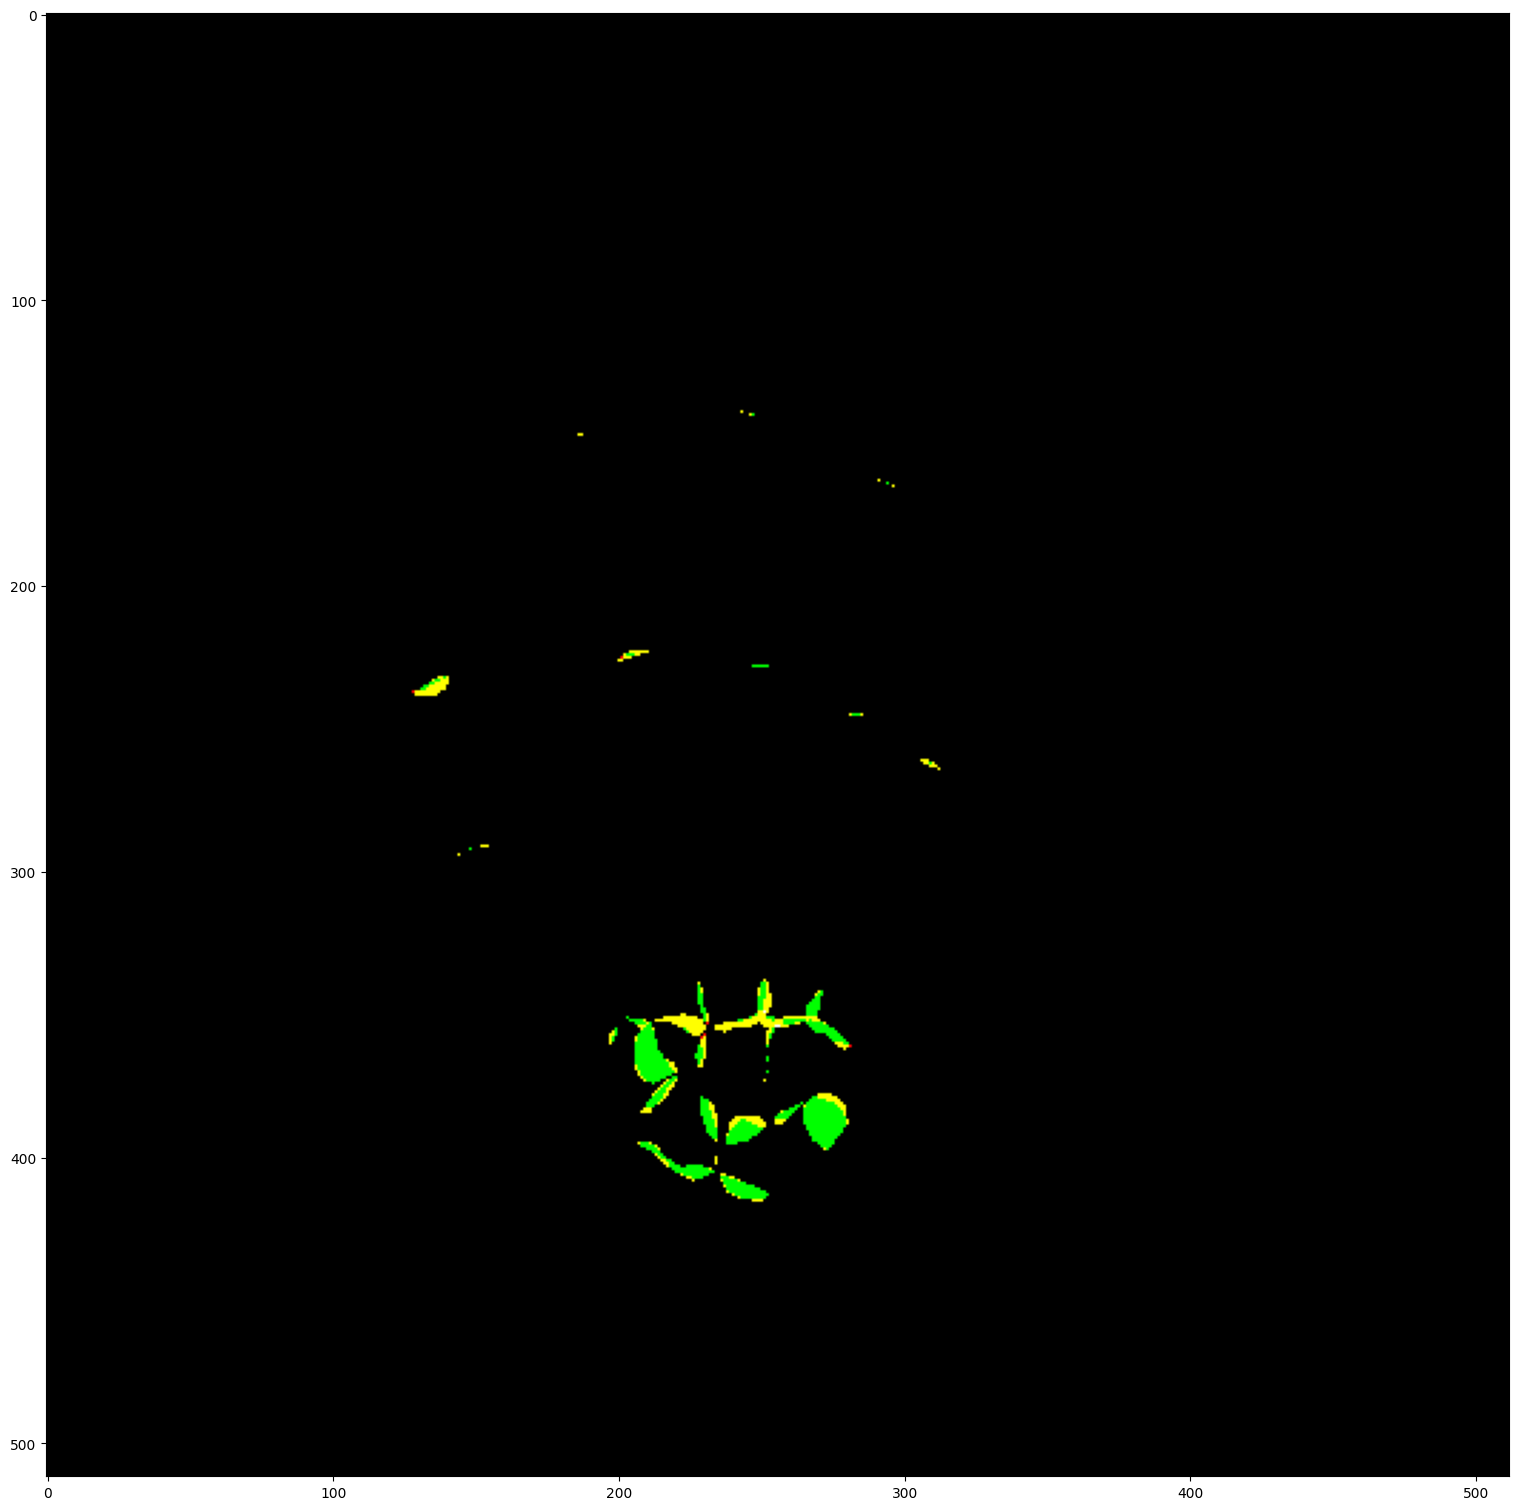

In [57]:
res_3ch = np.array([res,res,res])
res_3ch = np.transpose(res_3ch,(1,2,0))
# outputs = np.transpose(outputs,(1,2,0)) # 1038, 1920, 3
f1_res = np.multiply(f1,res_3ch)

fig = plt.figure(figsize=(19,19))


plt.imshow(f1_res)

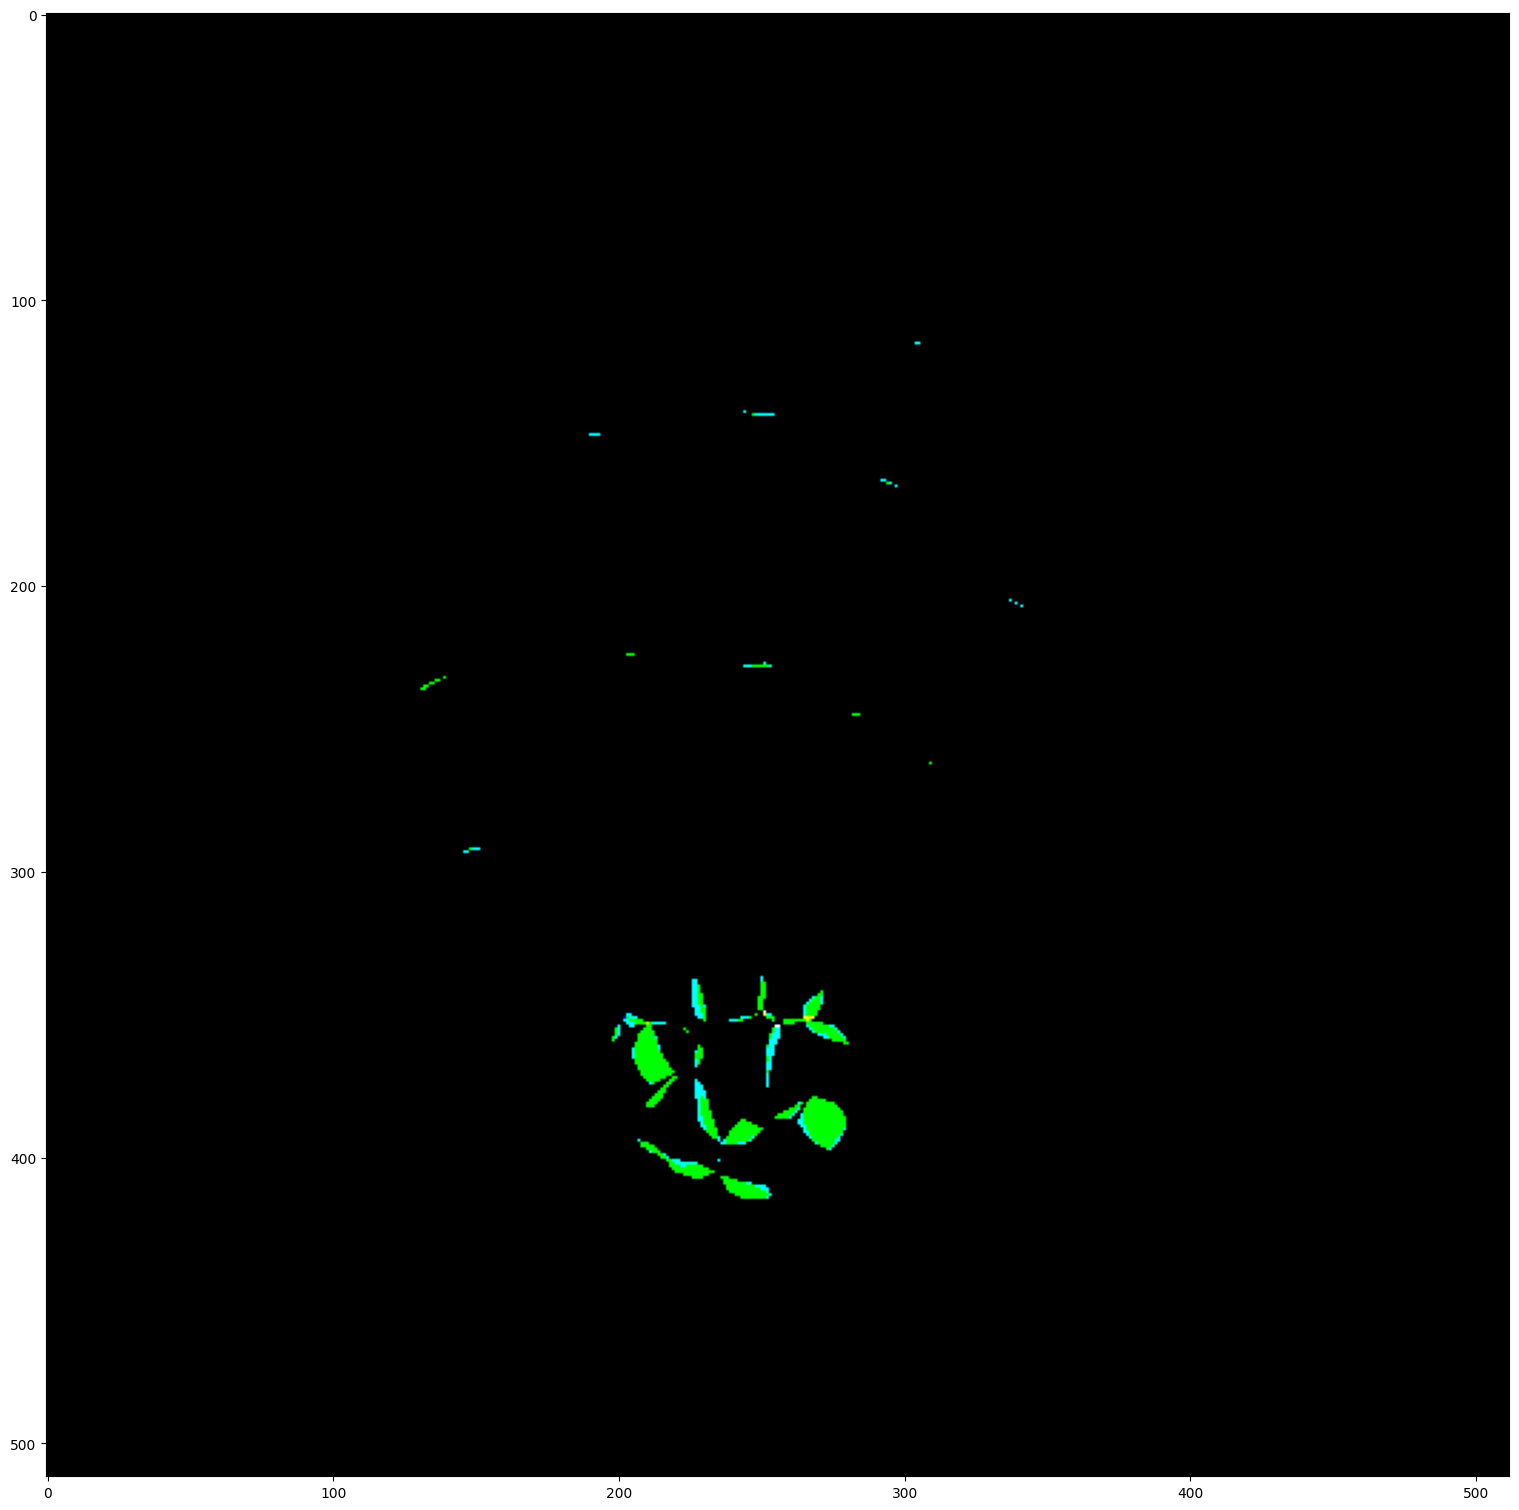

In [58]:
res2_3ch = np.array([res2,res2,res2])
res2_3ch = np.transpose(res2_3ch,(1,2,0))
# outputs = np.transpose(outputs,(1,2,0)) # 1038, 1920, 3
f1_res2 = np.multiply(f1,res2_3ch)
fig = plt.figure(figsize=(19,19))
plt.imshow(f1_res2)

최대로 겹친 구간 수 :  5.0
(512, 512)


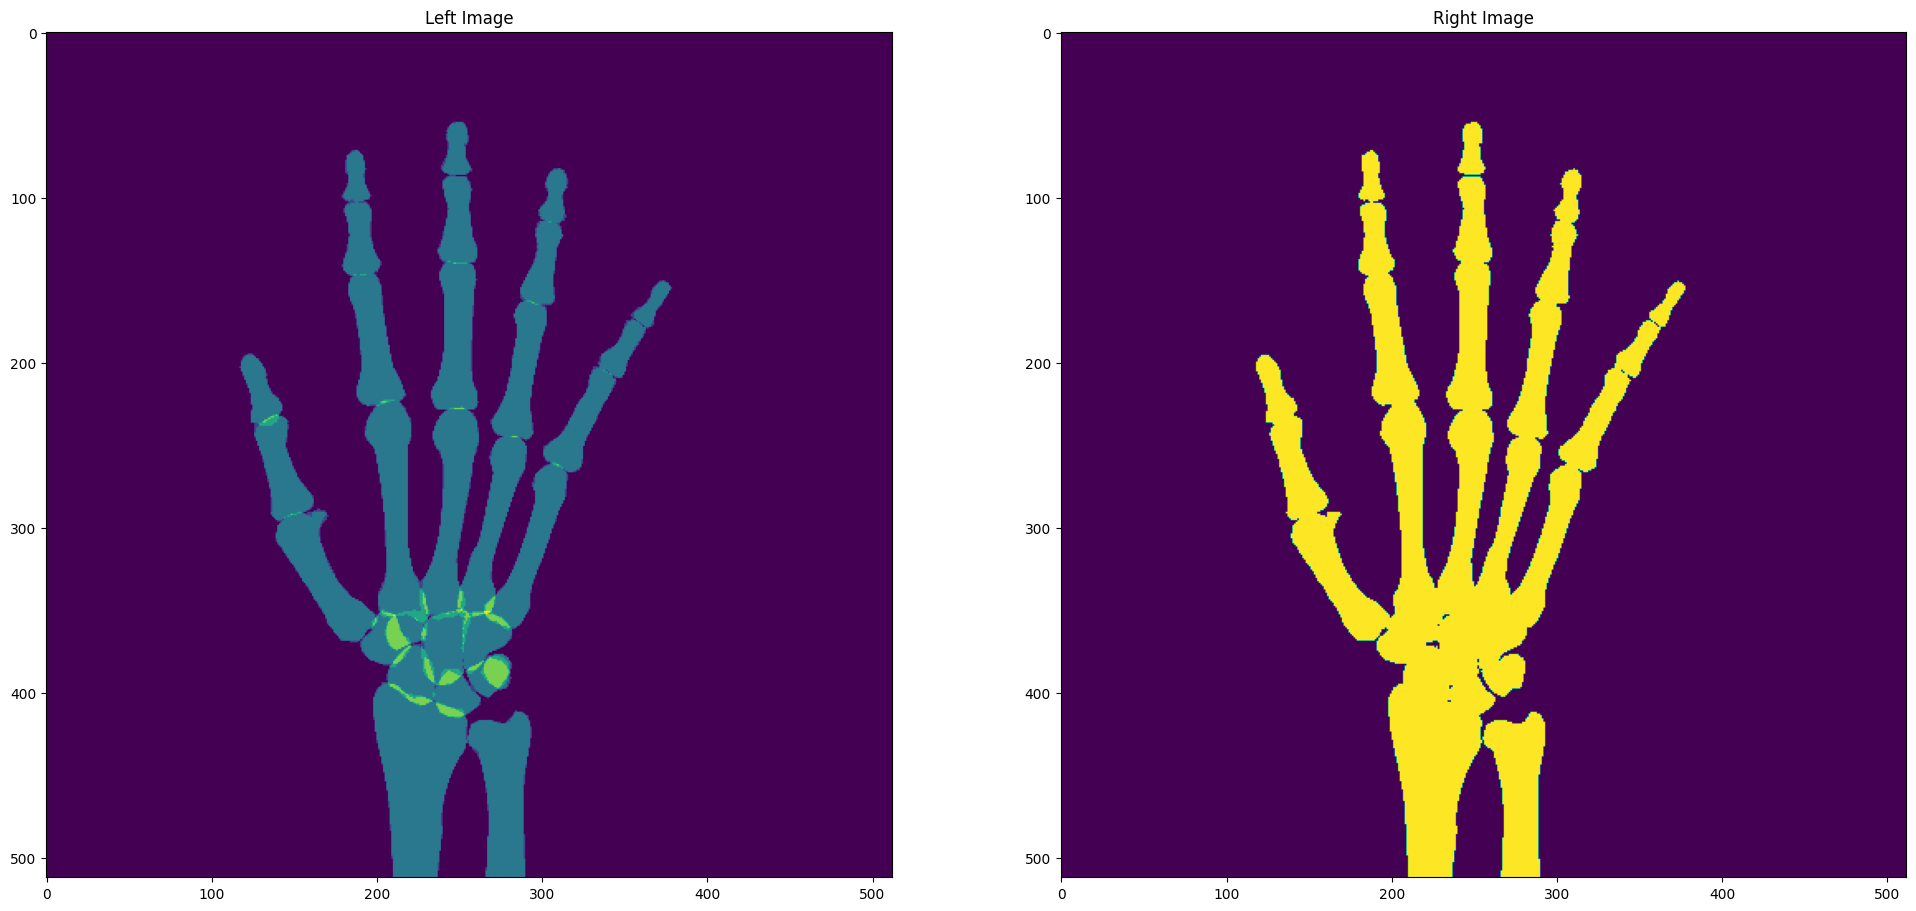

In [46]:
# image, label = valid_dataset[193]
input = label.numpy()
input = np.transpose(input,(1,2,0)) # 1038, 1920, 3

result = np.zeros((input.shape[0],input.shape[1]))



result = np.zeros((outputs.shape[0],outputs.shape[1]))


for i in range(29):
    # plt.imshow(outputs[:,:,i])
    # plt.show()
    result += outputs[:,:,i]

for i in range(29):
    # plt.imshow(input[:,:,i])
    # plt.show()
    result += input[:,:,i]
    
fig, ax = plt.subplots(1,2,figsize=(24, 12))
# plt.imshow(result)
ax[0].imshow(result)
ax[0].set_title('Left Image')



aa = list(result.flatten())
print('최대로 겹친 구간 수 : ',max(aa))

# print over 1
res = result.copy()
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        if res[i,j] > 1:
            res[i,j] = 1
        else:
            res[i,j] = 0

print(res.shape)
# plt.imshow(res)

# Plotting the right image
ax[1].imshow(res)
ax[1].set_title('Right Image')


# Adjusting the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()



In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input = torch.arange(0, 16, dtype=torch.float32).reshape(1, 1, 4, 4)
# size : torch.Size([1, 1, 4, 4])
# value : tensor([[[[ 0.,  1.,  2.,  3.],
#                   [ 4.,  5.,  6.,  7.],
#                   [ 8.,  9., 10., 11.],
#                   [12., 13., 14., 15.]]]])
print('##############    interpolate 하기 전    ##############')
print(input)
# mode='nearest'
output = F.interpolate(input, size=(8,8), mode="bilinear")
# tensor([[[[ 0.,  0.,  1.,  1.,  2.,  2.,  3.,  3.],
#           [ 0.,  0.,  1.,  1.,  2.,  2.,  3.,  3.],
#           [ 4.,  4.,  5.,  5.,  6.,  6.,  7.,  7.],
#           [ 4.,  4.,  5.,  5.,  6.,  6.,  7.,  7.],
#           [ 8.,  8.,  9.,  9., 10., 10., 11., 11.],
#           [ 8.,  8.,  9.,  9., 10., 10., 11., 11.],
#           [12., 12., 13., 13., 14., 14., 15., 15.],
#           [12., 12., 13., 13., 14., 14., 15., 15.]]]])
output = output.numpy()
print()
print()
from pprint import pprint
print('##############    interpolate한 후 => 크기가 2배됨 + mode : bilinear  ##############')
pprint(output)

##############    interpolate 하기 전    ##############
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])


##############    interpolate한 후 => 크기가 2배됨 + mode : bilinear  ##############
array([[[[ 0.  ,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.  ],
         [ 1.  ,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.  ],
         [ 3.  ,  3.25,  3.75,  4.25,  4.75,  5.25,  5.75,  6.  ],
         [ 5.  ,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.  ],
         [ 7.  ,  7.25,  7.75,  8.25,  8.75,  9.25,  9.75, 10.  ],
         [ 9.  ,  9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.  ],
         [11.  , 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.  ],
         [12.  , 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.  ]]]],
      dtype=float32)
